## Active Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sbi
sbi.__version__

'0.18.0'

In [3]:
import torch
from torch import ones, zeros, eye

from sbi.inference import SNLE, SNPE
from sbi.utils.torchutils import atleast_2d
from sbi.analysis import pairplot
from sbi.inference import MCMCPosterior, RejectionPosterior, VIPosterior
from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

from copy import deepcopy

import matplotlib.pyplot as plt

from loss_calibration.loss import StepLoss_weighted, SigmoidLoss_weighted
import loss_calibration.lotka_volterra as lv
from loss_calibration.utils import format_axis

Prior and Simulator

In [4]:
prior = lv.get_prior()
sim = lv.get_simulator()

Define a potential

In [5]:
class AcquisitionPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o, device="cpu"):
        super().__init__(prior, x_o, device=device)
    
    def __call__(self, theta, track_gradients=True):
        with torch.set_grad_enabled(track_gradients):
            return torch.log(acquisition_fn(theta))


Define a cost function and an acquisition function

In [6]:
costs = [2,1]
threshold = 0.8
threshold_dim=0
#cost_fn = StepLoss_weighted([2,1], 0.)    # ! torch.gt breaks backward pass of gradients
cost_fn = SigmoidLoss_weighted(costs, threshold)

In [7]:
num_monte_carlo_samples_likelihood = 5
num_monte_carlo_samples_posterior = 1

In [8]:
def acquisition_fn(theta_0):
    theta_0 = atleast_2d(theta_0)
    # 1.sample from likelihood
    predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0) 
    predicted_theta_given_x = []
    # 2. for each sampled x, sample from the posterior
    for px in predicted_x.swapaxes(0,1):
        predicted_theta_given_x.append(posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px))
    predicted_theta_given_x = torch.cat(predicted_theta_given_x, dim=1) 
    # 3. calculate associated cost
    predicted_decision = (predicted_theta_given_x > threshold).float()
    estimated_cost = cost_fn(theta_0[:,threshold_dim].unsqueeze(1).repeat(1,num_monte_carlo_samples_likelihood), predicted_decision[:,:,threshold_dim])
    return estimated_cost.mean(dim=1)

In [9]:
n_rounds = 5
proposal = prior

# inference objects
inference_likelihood = SNLE(prior)
inference_posterior = SNPE(prior)

proposals = []
likelihood_estimators = []
posterior_estimators = []

for r in range(n_rounds): # rounds
    print(f'\n----- ROUND {r} -----')
    theta = proposal.sample((100,)) #1000
    x = sim(theta)
    # train both SNLE and SNPE
    likelihood_estimator = inference_likelihood.append_simulations(theta, x).train(max_num_epochs=10) #100
    print('\n')
    posterior_estimator = inference_posterior.append_simulations(theta, x, proposal=proposal).train(max_num_epochs=10) #100

    potential = AcquisitionPotential(prior, x_o=zeros(1, 2), device="cpu")
    acquisition_sampler = RejectionPosterior(potential_fn=potential, proposal=prior)

    #acquisition_sampler = RejectionPosterior(potential_fn=potential, proposal=prior, init_method="sir", method="slice_np_vectorized", nujmj_chains=100)
    proposal = acquisition_sampler

    likelihood_estimators.append(deepcopy(likelihood_estimator))
    posterior_estimators.append(deepcopy(posterior_estimator))
    proposals.append(deepcopy(proposal))
    torch.save(theta, f"./results/lotka_volterra/active_learning/round{r}_sampled_theta.pt")
    torch.save(proposal, f"./results/lotka_volterra/active_learning/round{r}_proposal.pt")
    torch.save(likelihood_estimator, f"./results/lotka_volterra/active_learning/round{r}_likelihood_estimator.pt")
    torch.save(posterior_estimator, f"./results/lotka_volterra/active_learning/round{r}_posterior_estimator.pt")


----- ROUND 0 -----


/Users/mgorecki/.virtualenvs/bm_venv_sbi18/lib/python3.8/site-packages/diffeqtorch/diffeqtorch.py:255: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  u = torch.tensor(u).T


 Training neural network. Epochs trained: 11

 Training neural network. Epochs trained: 11
----- ROUND 1 -----


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 97
                        samples. Consider interrupting (Ctrl-C) and switching to
                        `sample_with='mcmc`.


 Training neural network. Epochs trained: 11

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 11
----- ROUND 2 -----


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 99
                        samples. Consider interrupting (Ctrl-C) and switching to
                        `sample_with='mcmc`.


 Training neural network. Epochs trained: 11

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 11
----- ROUND 3 -----


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 93
                        samples. Consider interrupting (Ctrl-C) and switching to
                        `sample_with='mcmc`.


 Training neural network. Epochs trained: 11

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 11
----- ROUND 4 -----


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 89
                        samples. Consider interrupting (Ctrl-C) and switching to
                        `sample_with='mcmc`.


 Training neural network. Epochs trained: 11

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 11

In [10]:
n_samples_proposal = 1000
samples_proposal = proposal.sample((n_samples_proposal,))
samples_prior = prior.sample((10,))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 995
                        samples. Consider interrupting (Ctrl-C) and switching to
                        `sample_with='mcmc`.


In [11]:
samples_proposal_potential = [potential(s) for s in samples_proposal]

In [16]:
samples_proposal_potential = torch.stack(samples_proposal_potential)

Visualize the potential

In [1]:
samples_proposal[:,3].max()

NameError: name 'samples_proposal' is not defined

In [112]:
resolution = 100
alphas = torch.linspace(0,10, resolution)
betas = torch.linspace(0,1, resolution)
gammas = torch.linspace(0,10, resolution)
deltas = torch.linspace(0,1, resolution)
#torch.meshgrid([alphas, betas, gammas, deltas])

In [113]:
a,b,c,d = torch.meshgrid([alphas, betas, gammas, deltas])
thetas_grid = torch.vstack([a.ravel(), b.ravel(), c.ravel(), d.ravel()]).T
thetas_grid_potential = potential(thetas_grid)

: 

: 

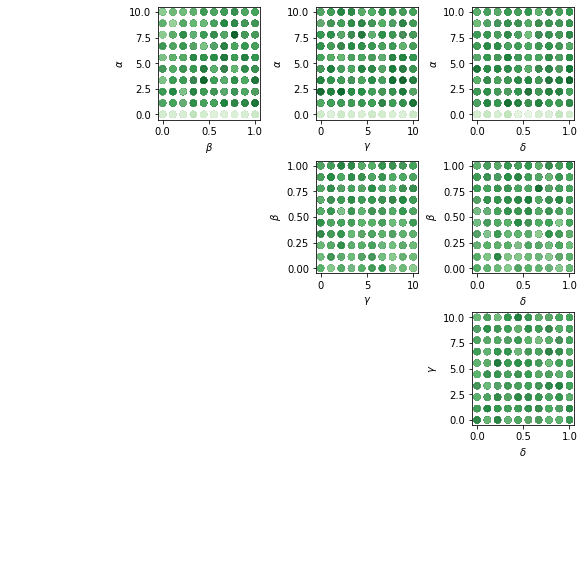

In [111]:
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, constrained_layout=True, figsize=(8,8))
for r in range(rows): 
    for c in range(cols): 
        if r==c: 
            # hist for single parameter
            #format_axis(axes[r,c], xhide=False, xlabel=labels[c], yhide=True,)
            #axes[r,c].scatter(samples_proposal[:, r], samples_proposal_potential)
            axes[r,c].axis("off")
        elif r < c:
            # plot 
            #format_axis(axes[r,c], xhide=True, yhide=True,)
            axes[r,c].scatter(thetas_grid[:, c], thetas_grid[:, r], c=thetas_grid_potential.exp(), cmap="Greens", alpha=0.2)
            axes[r,c].set_xlabel(labels[c])
            axes[r,c].set_ylabel(labels[r])
        else: 
            axes[r,c].axis("off")

In [ ]:
thetas_linspace = torch.linspace(-1,1,500)
n_potential = 50
potential_thetas_linspace = torch.cat([torch.stack([potential(th) for th in thetas_linspace], dim=1) for r in range(n_potential)])

In [ ]:
single_potential_thetas_linspace = torch.cat([potential(th) for th in thetas_linspace])
single_potential_thetas_linspace.shape

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.plot(thetas_linspace.numpy(), single_potential_thetas_linspace.exp().numpy())
ax.vlines(0.0, ymin=-0.05, ymax=max(single_potential_thetas_linspace)+0.05, color='r')
ax.set_ylabel('potential')
ax.set_xlabel(r'$\theta$')
ax.set_title("Single potential evaluated on linspace")
fig.savefig("./results/active_learning/lv_single_potential.jpg")

In [ ]:
mean_potential = potential_thetas_linspace.exp().mean(dim=0)
std_potential = potential_thetas_linspace.exp().std(dim=0)

fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.plot(thetas_linspace, mean_potential)
ax.fill_between(thetas_linspace.numpy(), (mean_potential-std_potential).numpy(), (mean_potential+std_potential).numpy(), alpha=0.2)
ax.vlines(0.0, ymin=-0.05, ymax=max(mean_potential+std_potential)+0.05, color='r')
ax.set_ylabel('potential')
ax.set_xlabel(r'$\theta$')
ax.set_title(f"Mean and std over {n_potential} potentials evaluated on linspace")
fig.savefig("./results/active_learning/lv_potential.jpg")

In [ ]:
potentials_samples_proposal = [potential(s).exp().item()  for s in samples_proposal]

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.hist(potentials_samples_proposal)
ax.set_xlabel('potential')
ax.set_ylabel('frequency')
ax.set_title(f"Histogram over potentials of {n_samples_proposal} samples from the proposal")
fig.savefig("./results/active_learning/lv_potential_histogram.jpg")
plt.show()


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.hist(torch.round(samples_proposal, decimals=2).numpy(), bins=50)
ax.set_xlabel('sample')
ax.set_ylabel('frequency')
ax.set_title(f"Histogram over {n_samples_proposal} samples from the proposal")
fig.savefig("./results/active_learning/lv_potential_samples_proposal.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.scatter(samples_proposal, potentials_samples_proposal, alpha=0.4)
ax.set_xlabel('sample')
ax.set_ylabel('potential')